# Importing libraries

In [120]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import scikitplot as skplt

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, precision_score, recall_score

#from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

#from catboost import CatBoostRegressor
#from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
#from lightgbm import LGBMRegressor
#from sklearn.ensemble import GradientBoostingRegressor
#from xgboost import XGBRegressor

#import optuna

In [121]:
data = pd.read_csv("framingham.csv")
data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


# Data cleaning

### Droping columns

In [122]:
data1 = data.copy()

In [123]:
data1 = data.drop(["education"],axis=1)

In [124]:
data1.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [125]:
data1.isna().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [126]:
data1 = data1.dropna(subset=["cigsPerDay"])
data1 = data1.dropna(subset=["BPMeds"])
data1 = data1.dropna(subset=["totChol"])
data1 = data1.dropna(subset=["BMI"])
data1 = data1.dropna(subset=["heartRate"])

### Imputing missing value in data

In [127]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target] ##all the values of column(na_target) that are not missing.
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns] ##all the other column(leaving na_target) with no missing value
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [128]:
data1 = knn_impute(data1,"glucose")

In [129]:
data1.isna().sum().sum()

0

In [130]:
data1 = data1.reset_index(drop=True)

# Picking target

In [131]:
data2 = data1.copy()

In [132]:
target = data2["TenYearCHD"]
target

0       0
1       0
2       0
3       1
4       0
       ..
4083    1
4084    1
4085    0
4086    0
4087    0
Name: TenYearCHD, Length: 4088, dtype: int64

In [133]:
data2 = data2.drop(["TenYearCHD"],axis=1)

In [134]:
data2.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0


# Data visualization

Text(0.5, 0, 'Heart Attack risk')

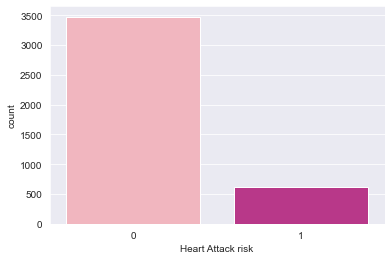

In [135]:
sns.countplot(x = target, palette= 'RdPu')
plt.xlabel('Heart Attack risk')

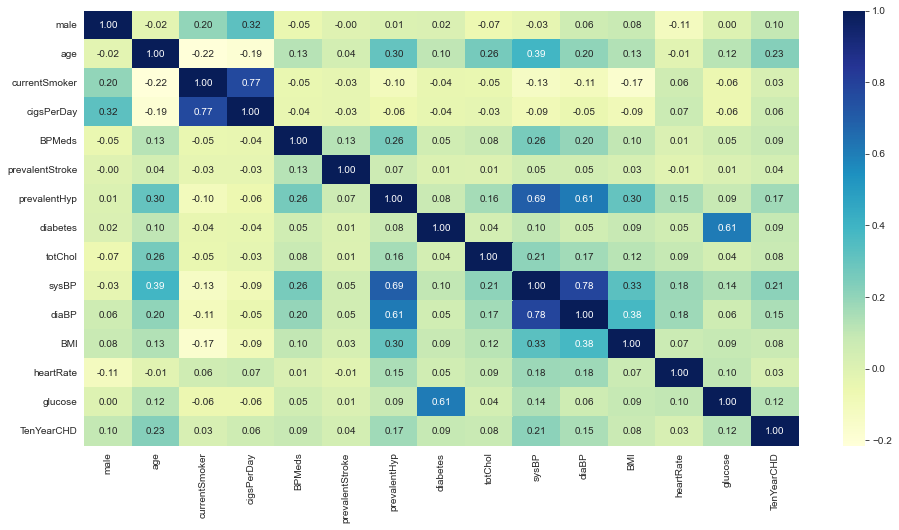

In [136]:
plt.figure(figsize= (16, 8))
sns.heatmap(data1.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f');

# Feature Scaling

In [137]:
data3 = data2.copy()

In [138]:
sc = StandardScaler()
data3[["age",
"cigsPerDay",
"totChol",
"sysBP",
"diaBP",
"BMI",
"heartRate",
"glucose"]] = sc.fit_transform(data3[["age","cigsPerDay","totChol","sysBP","diaBP","BMI","heartRate","glucose"]])

In [139]:
data3.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,-1.229971,0,-0.755064,0.0,0,0,0,-0.937495,-1.197246,-1.088672,0.287219,0.345170,-0.208090
1,0,-0.410334,0,-0.755064,0.0,0,0,0,0.299536,-0.512432,-0.159498,0.718865,1.588610,-0.251529
2,1,-0.176152,1,0.924270,0.0,0,0,0,0.187079,-0.215679,-0.243968,-0.112544,-0.069310,-0.512159
3,0,1.346031,1,1.763937,0.0,0,1,0,-0.262751,0.811541,1.023087,0.682077,-0.898269,0.921310
4,0,-0.410334,1,1.176170,0.0,0,0,0,1.086737,-0.101544,0.093913,-0.661912,0.759650,0.139417


# Data spliting

In [140]:
data4 = data3.copy()

In [141]:
X_train, X_test, y_train, y_test = train_test_split(data4, target, test_size = 0.2)

In [142]:
X_train.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
2003,0,-0.176152,0,-0.755064,0.0,0,0,0,0.749365,0.081073,0.347324,-0.218003,-0.069310,-0.208090
1537,0,-1.229971,1,1.763937,0.0,0,1,0,-0.037836,2.911636,2.796965,0.956762,-0.235102,0.226294
2468,1,0.526394,0,-0.755064,0.0,0,1,0,-0.667597,0.628924,1.276498,-0.531928,-0.898269,0.400048
2194,0,0.058030,1,0.084603,0.0,0,1,0,0.074621,2.021379,2.712494,0.468707,-0.483790,0.052541
1005,0,-0.878698,0,-0.755064,0.0,0,0,0,-1.207392,-0.968975,-1.004201,-1.476154,-0.815373,-0.034336


In [143]:
y_train.head()

2003    0
1537    1
2468    1
2194    0
1005    0
Name: TenYearCHD, dtype: int64

In [144]:
X_test.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
2463,0,0.175121,0,-0.755064,0.0,0,0,0,-0.240259,-1.242900,-1.004201,0.473612,-0.649582,-0.121213
3300,1,-1.112880,1,0.924270,0.0,0,1,0,-0.645106,-0.603741,-1.426553,0.561903,-0.069310,-0.685913
1888,0,1.463122,0,-0.755064,0.0,0,1,0,0.569434,1.952897,0.178384,1.253518,-0.649582,-0.425282
2056,0,-1.464153,1,0.924270,0.0,0,0,0,-1.634730,-1.630961,-1.342083,-0.198383,-0.649582,-0.642475
2220,0,1.697304,0,-0.755064,0.0,0,1,0,0.209570,2.637711,1.445439,1.687617,1.339922,0.877871


In [145]:
y_test.head()

2463    0
3300    0
1888    0
2056    0
2220    0
Name: TenYearCHD, dtype: int64

# Model

In [146]:
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

### Prediction

In [147]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[693   5]
 [109  11]]


0.8606356968215159